

# 思路

## 解决一个什么问题？
预测test数据集中，每一个可交易的时间节点，是做【action】操作还是【pass】操作，可以转化为一个是否要做action的一个二分类问题。<br/>
我们预测的是当前这个时间节点，在给定了一坨feature之后，当前这个节点是否要action=1的一个二分类。<br/>
注意不是给定当前feature预测下一个或未来某个时间节点的二分类问题，所以数据加工上会简单一些。<br/>

evaluation原文如下：Each row in the test set represents a trading opportunity for which you will be predicting an action value, 1 to make the trade and 0 to pass on it.
<br/><br/>

## target是什么
我觉得探查数据之前应该先明确target。<br/>
你可能要问了，不就是上面是否要做action的二分类问题吗？<br/>
但实际上原数据集中给的并不是action这样一个label，而根据题意，每一个时间节点是否发生action并能不能产生reward，是由3个变量共同决定的：
* weight【大于零的浮点数】
* resp【浮点数】
* action【0或1】<br/><br/><br/>

## 评估公式解读
<br/><br/>
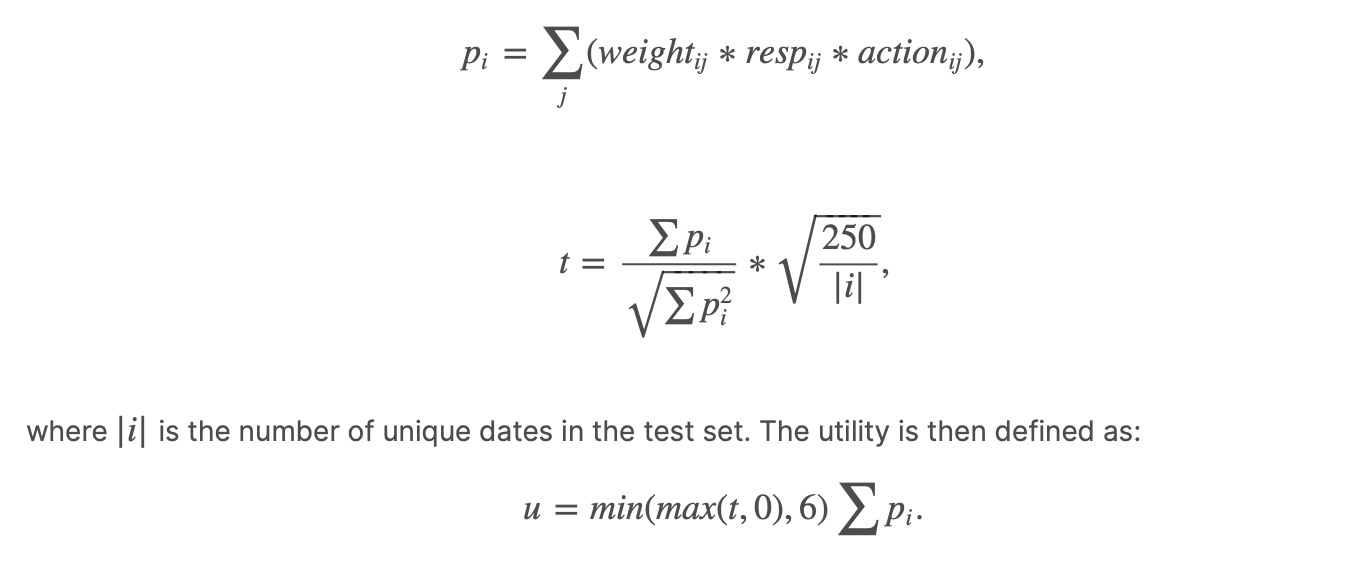
【公式1：当天总收益】<br/>
i表示某个date，j表示这天下的第几个交易行为，很好理解，就是相乘加和没什么好说的。<br/><br/><br/>
【公式2：收益放大率】<br/>
|i|表示就是你的test集里有多少天|i|就是多少（既然肯定>0那啥要做绝对值呢？不过也不重要）<br/><br/><br/>
【公式3：总收益utility】<br/>
先看公式的前半部分：min(max(t,0),6)，它会把公式2的结果收束到[0,6]这个范围内，再与公式1 summention over所有的date相乘就可以了<br/><br/><br/>

我发现了一个细节，就是evaluation公式里面，只给了一个respij（也就是在某日期下某时间节点，可以理解为发生买入或者卖出的的一个回报情况的一个估计）<br/>
但是数据中还有resp_1234这四个回报估计没有说<br/>
所以一般这种“赛方故意说的比较含糊”的点，会成为一个头部队伍拉开差距的地方。<br/><br/>
既然我们希望这个pi越大越好，且后面做的还是∑，所以我们要尽可能的保证respij是正数。<br/>
并且简单探查了一下数据发现，weight还有0的，所以【要把这些混淆视听的weight=0的sample全都剃掉】<br/><br/>
说了这么多那target到底是啥？<br/>
我觉得是一个比较开放性的判断，可以依次将每种resp都试一下，when resp_x > 0 then 1 else 0<br/>
或者将output做成5个target，最后对预测的output做个emsemble试试看也行。

## feature怎么加工
### 缺失值填充
看了下，130个特征里只有50个特征是完全没有NaN值的。<br/>
我把所有特征的分布拉了一下，是符合正态分布的，所以用mean填一下就行了。<br/>
（我还有想法用剩余的50个特征拟合一个Regression预测一下剩余feature里的NaN值，notebook GPU时间受限，暂时没时间搞了，感觉会有点用，不过应该不会有啥飞跃）<br/>
### 归一化
XGB的化就不用归一化，这个notebook用的NN，同样看了一下feature分布，都还比较均匀，所以不归一化也行（不排除是赛方提前给我们做了一轮加工？）<br/><br/>

## 用什么model
这个notebook我用的NN，其实我非常喜欢XGB的，有几个原因让我用了NN：<br/>
1、公司电脑还回去了，我自己的笔记本的XGB-GPU环境有问题，用optuna寻找最佳超参数太慢了，没时间折腾了。<br/>
2、notebook GPU时间上限也不算太充裕，不如单机debug来的方便。<br/><br/>
其实这个问题我觉得如果想从10% -> 1%冲击一下model是可以的，时间短的话别把太多精力放在model上，收益不大，折腾半天还容易overfitting<br/><br/>

## 如果给我一个月时间把这个比赛搞好？
* 调试5种resp做target比较花时间，这个应该没啥trick只能暴力试一下，毕竟赛方没给我们这几个值在金融领域的含义是啥。<br/>
* 用Regression把缺失值补一下。2.1：regression补还是会遇到数据穿越问题。<br/>
* 多模型融合：比如把GRU、NN的预测概率做平均。<br/>
* 做一些进阶的数据预处理，比如做一下分箱平滑一下噪音点等等（其实看分布感觉噪音并不明显，强行分箱不排除有效果变差的可能）<br/>
* 【一些特别玄学的东西很重要】泡在Discussion里多看看别人的思路，比如我看到一个Master说，date=85之前交易频率明显比86~500天要高，反正看大家聊了一通也不知道因为啥，大概率可能是因为交易模型在那个时候发生了改版？原来因为收益不行要较高的频率操作，之后行情好了放慢了频率？等等一些奇怪的猜测...反正我听取的建议，踢掉了前85天的train数据，效果是有提升的，约等于剃掉噪音点，只不过这个噪音是连续的一大坨。<br/>我还看到有人把预测的threshole上调了几个万分点，score又怼上去一点的例子...反正挺玄学的。

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

## TODO LIST（2.1更新）
* 做一个离线打public LB分数的函数（但是讨论区有人无论如何都不能把离线评估score跟LB score对齐，这里有坑），做一下valid调参【挺重要但是太费时间了，优先级下降，先用AUC吧】
* 开始做特征工程，先弄点滑窗特征看一下吧，从SQL转pandas真的非常不适应【doing】
* 再开一个notebook好好做一下EDA【doing，notebook还没有public】
* 有些feature不遵循正态分布，准备单独把这些feature抽出来单独train一下【优先级下降】
* 我发现别人的讨论区中抓出来哪几个特征共同组合成了stock_id，id特征理论上不应该参与到NN模型的训练当中的，我剔除一下看看【Done】
* 把股票id出现的频次分桶打成onehot【已放弃，不好用】
* 低买高卖特征【不行，没有类似表达股票价格的resp】
* 把weight当feature丢进去看看【doing】

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 一些想法
* 看了另一个大神的NN模型的讨论区，有一个GM说他fit的模型实际上在A榜是overfitting的，他俩差点没打起来，其实我觉得打初赛刷rank就是要不断的overfitting A榜的feature啊，我之前也有A榜冠军开心的一比，B榜overfitting直接变SB的经历。反正我觉得吧，现在这个Leaderboard没啥太大的参考意义，我觉得头部队伍到了B榜基本全部都要完蛋的节奏（当然如果你只是刷A榜型选手那当我没说）
* 【玄学事件】有关随机种子的问题我看讨论区也有很多人讨论，不同的随机种子会造成甚至上千的score差异，如果一个模型fit的相对比较完美是不可能出现这种情况的，非常迷，这块我暂时再观察一下讨论区看看，截止到1.26还没什么想法。1.28：主观感觉应该是overfitting了。2.1：确实是overfitting了
* 这个问题既然是多目标优化问题，那为什么不把weight当成一个target优化呢，我看完全没有人这么做，试一试？【不行不能当target，只能当feature试一下】
* 玩股票里头有一个很重要的事情就是低买高卖，“低买高卖”怎么做一个特征感觉应该也能挺有用，准备试一下【行不通，因为没有表征“价格”的信息】
* feature_64这个特征的含义是当时做trade的时间点，这个看看怎么能搞一下，后续思路会写在这【暂时没什么办法】

## Loading dataset...

In [ ]:
# coding: utf-8

import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_addons as tfa
import datatable as dt


#  初始化一个随机数种子
SEED = 1111
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Loading data...')

train_datatable = dt.fread('/kaggle/input/jane-street-market-prediction/train.csv')  # 用datatable会快一点
train = train_datatable.to_pandas()
del train_datatable

display(train)

## Data preprocessing...

In [ ]:
print('Data preprocessing...')

train = train.query('date > 85').reset_index(drop = True)   # 只保留第86天及以后的data
train = train[train['weight'] > 0]

features = []
for item in train.columns:
#     if 'feature' in item or 'weight' in item:
    if 'feature' in item:
        features.append(item)
# print(features)

features_mean = train.loc[:, features].mean()

train.fillna(train.mean(),inplace=True)  # 注意，这种暴力mean的方案会数据穿越导致overfitting，所以应该滚动mean会更加“正确”，但是public LB-score应该会更低

print('Done!')

# Merge and drop features...
现在特征被打成了三个部分：<br/>
1、原始特征<br/>
2、f0：是买还是卖的这个onehot<br/>
3、f41+f42+f43 共同组成的stock_id的onehot<br/><br/>
下面要做的其实是把这三个部分拼起来，并把之前没用的特征drop掉

In [ ]:
# print('Merge features...')

# train['stock_id'] = train['feature_41'] + train['feature_42'] + train['feature_43']
# features.append('stock_id')

# display(train)

# print('Done!')

## Make X and y...

In [ ]:
# VALID_DAYS = 50  # using for valid
VALID_DAYS = 0   # using for LB
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']

# ------------------------------- #
#            NN sample            #
# ------------------------------- #
print('Make NN sample...')
# train
X_train = train[train['date'] <= 499-VALID_DAYS]
y_train = np.stack([(X_train[c]>0).astype('int') for c in resp_cols]).T
X_train = X_train.loc[:, features].values
print(X_train.shape, y_train.shape)

# valid
X_valid = train[train['date'] > 499-VALID_DAYS]
y_valid = np.stack([(X_valid[c]>0).astype('int') for c in resp_cols]).T
X_valid = X_valid.loc[:, features].values
print(X_valid.shape, y_valid.shape)

# ------------------------------- #
#            RNN sample           #
# ------------------------------- #
# print('\nMake RNN sample...')
# # train
# SEQUENCE_LENGTH = 64
# X_RNN_train = []
# y_RNN_train = []
# X_RNN_train_sample = train[train['date'] <= 499-VALID_DAYS].loc[:, features].values
# y_RNN_train_sample = train[train['date'] <= 499-VALID_DAYS].loc[:, resp_cols].values
# for i in range(0, len(X_train)-SEQUENCE_LENGTH, 64):
#     X_RNN_train.append(X_RNN_train_sample[i:i+SEQUENCE_LENGTH].tolist())
#     y_RNN_train.append(y_RNN_train_sample[i+SEQUENCE_LENGTH-1].tolist())
#     if (i%10000) == 0 and i != 0:
#         print('process ' + str(i/10000) + 'w lines...')
        
# X_RNN_train = np.array(X_RNN_train) 
# for i in range(len(y_RNN_train)):
#     for j in range(len(y_RNN_train[0])):
#         if y_RNN_train[i][j] > 0:
#             y_RNN_train[i][j] = 1
#         else:
#             y_RNN_train[i][j] = 0
# y_RNN_train = np.array(y_RNN_train)
# print('X_RNN_train shape: ', X_RNN_train.shape)
# print('y_RNN_train shape: ', y_RNN_train.shape)
        
print('Done!')

## Define NN models...

In [ ]:
print('Create NN models...')

# ------------------------------------------- #
#                   model                     #
# ------------------------------------------- #
HIDDEN_LAYER_1 = [256, 256]
HIDDEN_LAYER_2 = [160, 160, 160]
HIDDEN_LAYER_3 = [128, 128, 128, 128]
TARGET_NUM = 5   # 优化那5个resp

input = tf.keras.layers.Input(shape=(X_train.shape[1], ))

#part_1
x1 = tf.keras.layers.BatchNormalization()(input)
x1 = tf.keras.layers.Dropout(0.25)(x1)
for units in HIDDEN_LAYER_1:
    x1 = tf.keras.layers.Dense(units)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation(tf.keras.activations.swish)(x1)
    x1 = tf.keras.layers.Dropout(0.25)(x1)

# part_2
x2 = tf.keras.layers.BatchNormalization()(input)
x2 = tf.keras.layers.Dropout(0.25)(x2)
for units in HIDDEN_LAYER_2:
    x2 = tf.keras.layers.Dense(units)(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Activation(tf.keras.activations.swish)(x2)
    x2 = tf.keras.layers.Dropout(0.25)(x2)
    
# part_3
x3 = tf.keras.layers.BatchNormalization()(input)
x3 = tf.keras.layers.Dropout(0.25)(x3)
for units in HIDDEN_LAYER_3:
    x3 = tf.keras.layers.Dense(units)(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Activation(tf.keras.activations.swish)(x3)
    x3 = tf.keras.layers.Dropout(0.25)(x3)

x = tf.keras.layers.concatenate([x1, x2, x3])
x = tf.keras.layers.Dense(TARGET_NUM)(x)

output = tf.keras.layers.Activation("sigmoid")(x)

model = tf.keras.models.Model(inputs=input, outputs=output)
model.compile(
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=1e-3),
    metrics   = tf.keras.metrics.AUC(name="AUC"),
    loss      = tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
)

from keras.utils import plot_model
display(plot_model(model))

print('Done!')

## Train NN...

In [ ]:
print('Train NN...')

history = model.fit(
    x = X_train, 
    y = y_train, 
    epochs=25, 
    batch_size=4096, 
    validation_data=(X_valid, y_valid),
#     callbacks = EarlyStopping(monitor='roc_auc', patience=20, verbose=2, mode='max')
)
models = []
models.append(model)

print('Done!')

## See what is the Learning Curve looks like...

Accroding to this learning curve.<br/>
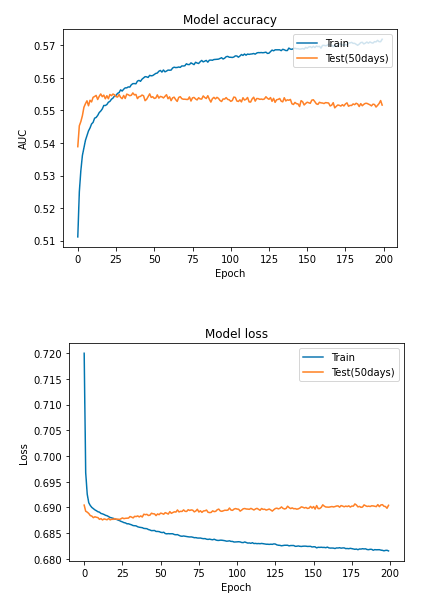
Maybe 25 epoch is a better chioce? <br/>

In [ ]:
# print('See what is the Learning Curve looks like...')
# import matplotlib.pyplot as plt

# # 绘制训练 & 验证的准确率值
# plt.plot(history.history['AUC'])
# plt.plot(history.history['val_AUC'])
# plt.title('Model accuracy')
# plt.ylabel('AUC')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test(50days)'], loc='upper right')
# plt.show()

# # 绘制训练 & 验证的损失值
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test(50days)'], loc='upper right')
# plt.show()

## Free the Memory...

In [ ]:
# del X_train, y_train

## Predict...

In [ ]:
THRESHOLD = 0.502

import janestreet
from tqdm import tqdm
janestreet.make_env.__called__ = False
env = janestreet.make_env()

print('predicting...')

for (test_df, pred_df) in tqdm(env.iter_test()):
    if test_df['weight'].item() > 0:
        
        X_test = test_df.loc[:, features].values
        if np.isnan(X_test.sum()):  # 用numpy填充，速度会比较快
            X_test = np.nan_to_num(X_test) + np.isnan(X_test) * features_mean.values
        pred = model(X_test, training = False).numpy()
        pred = np.mean(pred)
        
        pred_df.action = np.where(pred >= THRESHOLD, 1, 0).astype(int)

    else:
        pred_df.action = 0
    env.predict(pred_df)